# Import Packages

In [ ]:
import kagglehub

import os
import glob
import random
import json
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, learning_curve as sk_learning_curve
import sklearn.preprocessing as sk_preprocess
from sklearn.pipeline import Pipeline as sk_pipeline
import sklearn.multioutput as sk_multioutput
import sklearn.multiclass as sk_multiclass
import sklearn.linear_model as sk_linear
import sklearn.tree as sk_tree
import sklearn.ensemble as sk_ensemble
import sklearn.neighbors as sk_neighbors
import sklearn.naive_bayes as sk_naive_bayes
import sklearn.svm as sk_svm
import sklearn.metrics as sk_metrics
import sklearn.gaussian_process as sk_gaussian_process
import sklearn.cross_decomposition as sk_cross_decomposition
import sklearn.neural_network as sk_neural_network

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as keras_layers

import transformers as tfs

import cv2
import skimage

from google.colab import drive

In [ ]:
tf.__version__

'2.18.0'

In [ ]:
sklearn.__version__

'1.6.1'

# Download Data From Kaggle

In [ ]:
!mkdir -p ~/.kaggle

!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kapturovalexander/consumer-sentiments-and-ratings

Dataset URL: https://www.kaggle.com/datasets/kapturovalexander/consumer-sentiments-and-ratings
License(s): CC0-1.0


In [ ]:
!unzip /content/consumer-sentiments-and-ratings.zip

Archive:  /content/consumer-sentiments-and-ratings.zip
  inflating: market_comments.csv     


# Read The CSV File

In [ ]:
df = pd.read_csv("/content/market_comments.csv")

In [ ]:
len(df)

14281

In [ ]:
df.head()

,item_category,item_id,brand,user_id,date,comment,rating,tonality
0,401,4010201,826,2217,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",2.0,negative
1,403,4030101,1425,1026,2010-07-04,Через 2 месяца после истечении гарантийного ср...,2.0,negative
2,401,4010401,124,2769,2010-05-27,пользуюсь уже три недели. нареканий ни каких н...,4.0,positive
3,203,2030301,93,508,2016-10-11,Ребят этот системный блок подойдёт для игры кс...,5.0,positive
4,205,2050201,656,1049,2010-02-26,"я считаю, что яри замечательный телефон! Прият...",5.0,positive


In [ ]:
df.isna().sum()

,0
item_category,0
item_id,0
brand,0
user_id,0
date,0
comment,0
rating,0
tonality,0


# Seperate Into X and y

In [ ]:
X = df["comment"].to_numpy()

In [ ]:
X

array(['2,5 года работала и все...устала! Лампочка горит и больше ничего!',
       'Через 2 месяца после истечении гарантийного срока машинка навернулась. Насчитали ремонту на 5500р! Причем брал её итальянской сборки!  Сама машинка была нормальная, правда после стирки снова прополаскивал, но это пожалуй про любую так скажешь - плохо выполаскивается порошок, хотя и сыплю/лью по инструкции и не фигню какую...  А мастер авторизованного сервис-центра поведал мне много интересного... Нет смысла переплачивать сегодня за европейскую страну изготовителя, нет смысла приобретать машинки дороже 12-15 тыс., и что сейчас все производители заведомо делают машинки, чтобы те ломались побыстрее ( в среднем раз в 3-4 года!!!) тем самым стимулируя спрос на новые... Единственное, что еще живо в отношении реального КАЧЕСТВА, так это пожалуй немецкое "Миеле" (Бош кстати давно в пролете уже, скатился), но и они конечно тоже ломаются даже при стоимости в 100000... Вывод: Берем стиралку недорогую, тыщ за 8-10,

In [ ]:
y = df["rating"].to_numpy().astype(np.float32)

In [ ]:
y

array([2., 2., 4., ..., 5., 1., 5.], dtype=float32)

# Make Evaluate Function

In [ ]:
def evaluate_model(y_true, y_pred):
  y_pred = tf.squeeze(y_pred).numpy()

  metrics = {}

  metrics["MAE"] = sk_metrics.mean_absolute_error(y_true, y_pred)
  metrics["MSE"] = sk_metrics.mean_squared_error(y_true, y_pred)
  metrics["RMSE"] = np.sqrt(metrics["MSE"])
  metrics["MSLE"] = sk_metrics.mean_squared_log_error(y_true, np.maximum(y_pred, 0))
  metrics["MAPE"] = sk_metrics.mean_absolute_percentage_error(y_true, y_pred)
  metrics["MedAE"] = sk_metrics.median_absolute_error(y_true, y_pred)
  metrics["R2"] = sk_metrics.r2_score(y_true, y_pred)
  metrics["Explained Variance"] = sk_metrics.explained_variance_score(y_true, y_pred)

  return metrics

# Split Into Train Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(11424, 2857, 11424, 2857)

# Text Vectorizer

In [ ]:
x_len = [len(sentence.split()) for sentence in X_train]

x_len[:5]

[46, 42, 32, 22, 71]

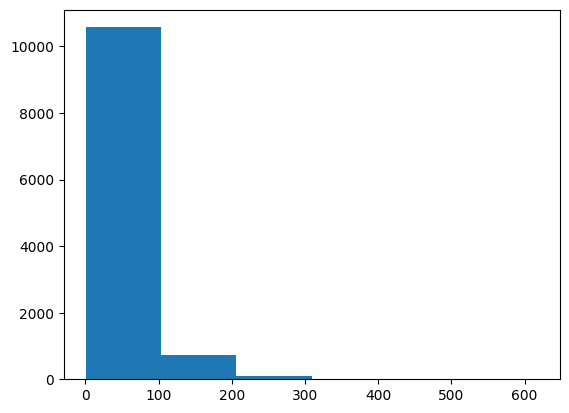

In [ ]:
plt.hist(x_len, bins = 6)
plt.show()

In [ ]:
avg_x_len = np.mean(x_len)

avg_x_len

np.float64(44.26593137254902)

In [ ]:
OUTPUT_SEQ_LEN = int(np.percentile(x_len, 95))

OUTPUT_SEQ_LEN

123

In [ ]:
MAX_TOKEN = 10000

In [ ]:
vectorizer = keras_layers.TextVectorization(
    max_tokens = MAX_TOKEN,
    output_sequence_length = OUTPUT_SEQ_LEN,
)

In [ ]:
vectorizer.adapt(X_train)

In [ ]:
print(X_train[0])
print('\n')
print(vectorizer(X_train[0]))

Телефон отличный.Берите-не пожалеете.Слышимость в трубе как-будто я с человеком рядом стою,дисплей яркими цветами можно на выбор украсить, в темноте клавиши все видно благодаря яркой,красивой неоново-синей подсветке, крупными буквами пишет в телефонной книге,что немаловажно людям с плохим зрением.В общем все ,что заявлено в описании работает на ура.


tf.Tensor(
[ 474    1    1    4    1 7198   19    7    1  897    1    1 6740   33
    5  309    1    4 2577 2136   11  473 1204    1    1 6243    1    1
 1417    4 8650    1 2848 2732    7 4798    1  100   11    6 2194    4
 1942   40    5  527    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(12

In [ ]:
text_vocab = vectorizer.get_vocabulary()

In [ ]:
len(text_vocab)

10000

In [ ]:
text_vocab[:5], text_vocab[-5:]

(['', '[UNK]', np.str_('и'), np.str_('не'), np.str_('в')],
 [np.str_('этапов'),
  np.str_('этапе'),
  np.str_('этап'),
  np.str_('этажа'),
  np.str_('эт')])

# Token Embedding

In [ ]:
embedding = keras_layers.Embedding(
    input_dim = len(text_vocab),
    output_dim = 256,
    # mask_zero = True,
    name = "token_embedding"
)

In [ ]:
print(X_train[0])
print(vectorizer(X_train[0]))
print(embedding(vectorizer(X_train[0])))

Телефон отличный.Берите-не пожалеете.Слышимость в трубе как-будто я с человеком рядом стою,дисплей яркими цветами можно на выбор украсить, в темноте клавиши все видно благодаря яркой,красивой неоново-синей подсветке, крупными буквами пишет в телефонной книге,что немаловажно людям с плохим зрением.В общем все ,что заявлено в описании работает на ура.
tf.Tensor(
[ 474    1    1    4    1 7198   19    7    1  897    1    1 6740   33
    5  309    1    4 2577 2136   11  473 1204    1    1 6243    1    1
 1417    4 8650    1 2848 2732    7 4798    1  100   11    6 2194    4
 1942   40    5  527    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(123,

# Several Model Experiment Variations

1. Feed Forward Neural Network
2. LSTM Regression
3. Bidirectional LSTM
4. GRU Regression
5. Bidirectional GRU
6. CNN Regression
7. LSTM + CNN Hybrid
8. Transformer Regression
9. BERT Embedding Regression

# Review The Train Data

In [ ]:
X_train

array(['Телефон отличный.Берите-не пожалеете.Слышимость в трубе как-будто я с человеком рядом стою,дисплей яркими цветами можно на выбор украсить, в темноте клавиши все видно благодаря яркой,красивой неоново-синей подсветке, крупными буквами пишет в телефонной книге,что немаловажно людям с плохим зрением.В общем все ,что заявлено в описании работает на ура.',
       'При переезде на новую квартиру,он потек при установке,отдали на гарантийный ремонт,оказалось техническая неисправность,обменяли на новый после 2-х лет использования,новый дали с сенсорной панелью и пультом управления,замечаний никаких нет,работает отлично уже 6 лет.Друзья тоже купили этой же фирмы только на 30л,тоже довольны,советую всем.',
       'Мультик детям понравился. Только высидеть 1,5 часа в бумажных анаглифных очках (к тому же не слишком то и удобных) оказалось трудно. При просмотре частенько очки приподнимаются на лоб (местами 3D эффект минимален).',
       ...,
       'Очень необычное ощущение  от бритья с испо

In [ ]:
X_train.shape

(11424,)

In [ ]:
y_train

array([5., 5., 4., ..., 5., 5., 5.], dtype=float32)

In [ ]:
y_train.shape

(11424,)

# Model 1: Feed Forward Neural Network

In [ ]:
inputs = keras_layers.Input(shape = (1,), dtype = tf.string)
x = vectorizer(inputs)
x = embedding(x)
x = keras_layers.GlobalMaxPool1D()(x)
x = keras_layers.Dense(64, activation  = "relu")(x)
x = keras_layers.Dense(32, activation = "relu")(x)
outputs = keras_layers.Dense(1, activation = "linear")(x)

model_1 = keras.Model(inputs, outputs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 123)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 123, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,578,561 (9.84 MB)

 Trainable params: 2,578,561 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_1.compile(
    loss = keras.losses.mae,
    optimizer = keras.optimizers.Adam(1e-4),
    metrics = ["mae"]
)

In [ ]:
model_1.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 32
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 2.4738 - mae: 2.4738
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.8842 - mae: 0.8842
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 0.8574 - mae: 0.8574
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.7878 - mae: 0.7878
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.7955 - mae: 0.7955
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 0.7707 - mae: 0.7707
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.7211 - mae: 0.7211
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.7060 - mae: 0.7060
Epoch 9/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 0.6478 - mae: 0.6478
Epoch 10/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.5978 - mae: 0.5978


In [ ]:
model_1_preds = model_1.predict(X_test)
model_1_preds

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[4.4758267],
       [4.648744 ],
       [4.861097 ],
       ...,
       [4.982058 ],
       [4.4150987],
       [3.483338 ]], dtype=float32)

In [ ]:
y_test

array([1., 4., 5., ..., 5., 5., 1.], dtype=float32)

In [ ]:
model_1_results = evaluate_model(y_test, model_1_preds)
model_1_results

{'MAE': 0.7142786383628845,
 'MSE': 1.3756029605865479,
 'RMSE': np.float64(1.1728610150339842),
 'MSLE': 0.11018163710832596,
 'MAPE': 0.4389786422252655,
 'MedAE': np.float32(0.3386979),
 'R2': 0.24511092901229858,
 'Explained Variance': 0.31036001443862915}

# Model 2: LSTM

In [ ]:
inputs = keras_layers.Input(shape = (1,), dtype = tf.string)
x = vectorizer(inputs)
x = embedding(x)
x = keras_layers.LSTM(128,return_sequences=True, activation = "relu")(x)
x = keras_layers.LSTM(64, activation = "relu")(x)
x = keras_layers.Dense(32, activation = "relu")(x)
outputs = keras_layers.Dense(1, activation = "linear")(x)

model_2 = keras.Model(inputs, outputs)

In [ ]:
model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 123)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 123, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 123, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,808,641 (10.71 MB)

 Trainable params: 2,808,641 (10.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_2.compile(
  loss = keras.losses.mae,
  optimizer = keras.optimizers.Adam(),
  metrics = ["mae"]
)

In [ ]:
model_2.fit(
  X_train,
  y_train,
  epochs = 3,
  batch_size = 200
)

Epoch 1/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 50.1554 - mae: 50.1554
Epoch 2/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - loss: 1.9743 - mae: 1.9743
Epoch 3/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 1.3860 - mae: 1.3860


In [ ]:
model_2_preds = model_2.predict(X_test)
model_2_preds

90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step


array([[4.3885994],
       [4.4352145],
       [4.387454 ],
       ...,
       [4.390561 ],
       [4.3882227],
       [4.3902435]], dtype=float32)

In [ ]:
y_test

array([1., 4., 5., ..., 5., 5., 1.], dtype=float32)

In [ ]:
model_2_results = evaluate_model(y_test, model_2_preds)
model_2_results

{'MAE': 1.173243761062622,
 'MSE': 2.7535457611083984,
 'RMSE': np.float64(1.659381137987412),
 'MSLE': 0.22134347259998322,
 'MAPE': 0.5660548210144043,
 'MedAE': np.float32(0.6115751),
 'R2': -0.5110621452331543,
 'Explained Variance': -0.5076507329940796}

# Model 3: Bidirectional LSTM

In [ ]:
inputs = keras_layers.Input(shape = (1,), dtype = tf.string)
x = vectorizer(inputs)
x = embedding(x)
x = keras_layers.Bidirectional(keras_layers.LSTM(128, return_sequences=True, activation = "relu"))(x)
x = keras_layers.Bidirectional(keras_layers.LSTM(64, activation = "relu"))(x)
x = keras_layers.Dense(32, activation = "relu")(x)
outputs = keras_layers.Dense(1)(x)

model_3 = keras.Model(inputs, outputs)

In [ ]:
model_3.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 123)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 123, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 123, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,122,753 (11.91 MB)

 Trainable params: 3,122,753 (11.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_3.compile(
  loss = keras.losses.mae,
  optimizer = keras.optimizers.Adam(),
  metrics = ["mae"]
)

In [ ]:
model_3.fit(
    X_train,
    y_train,
    epochs = 3,
    batch_size = 500
)

Epoch 1/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 161s 6s/step - loss: 10.9479 - mae: 10.9479
Epoch 2/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - loss: 3.4318 - mae: 3.4318
Epoch 3/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - loss: 3.0023 - mae: 3.0023


In [ ]:
model_3_preds = model_3.predict(X_test)
model_3_preds

90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step


array([[2.2397082],
       [2.1717   ],
       [2.3370464],
       ...,
       [2.2311852],
       [2.39002  ],
       [2.1189618]], dtype=float32)

In [ ]:
model_3_results = evaluate_model(y_test, model_3_preds)
model_3_results

{'MAE': 2.2588798999786377,
 'MSE': 5.714199542999268,
 'RMSE': np.float64(2.390439194583135),
 'MSLE': 0.32632753252983093,
 'MAPE': 0.5911482572555542,
 'MedAE': np.float32(2.4802873),
 'R2': -2.1357789039611816,
 'Explained Variance': -0.09724807739257812}

# Model 4: GRU

In [ ]:
inputs = keras_layers.Input(shape = (1,), dtype = tf.string)
x = vectorizer(inputs)
x = embedding(x)
x = keras_layers.GRU(128, activation = "relu", return_sequences=True)(x)
x = keras_layers.GRU(64, activation = 'relu')(x)
x = keras_layers.Dense(32, activation = "relu")(x)
outputs = keras_layers.Dense(1)(x)

model_4 = keras.Model(inputs, outputs)

In [ ]:
model_4.compile(
    loss = "mae",
    optimizer = "Adam",
    metrics = ["mae"]
)

In [ ]:
model_4.fit(
  X_train,
  y_train,
  epochs = 3,
  batch_size = 500
)

Epoch 1/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 3.1175 - mae: 3.1175
Epoch 2/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 1.2189 - mae: 1.2189
Epoch 3/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.9262 - mae: 0.9262


In [ ]:
model_4_preds = model_4.predict(X_test)
model_4_preds

90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step


array([[4.75399  ],
       [4.7525992],
       [4.7539997],
       ...,
       [4.753978 ],
       [4.753992 ],
       [4.753974 ]], dtype=float32)

In [ ]:
model_4_results = evaluate_model(y_test, model_4_preds)
model_4_results

{'MAE': 0.8828815221786499,
 'MSE': 2.1476006507873535,
 'RMSE': np.float64(1.4654694301783826),
 'MSLE': 0.1520707756280899,
 'MAPE': 0.5569552779197693,
 'MedAE': np.float32(0.24637318),
 'R2': -0.17853784561157227,
 'Explained Variance': -0.03571808338165283}

# Model 5: Bidirectional GRU

In [ ]:
inputs = keras_layers.Input(shape = (1,), dtype = tf.string)
x = vectorizer(inputs)
x = embedding(x)
x = keras_layers.Bidirectional(keras_layers.GRU(128, return_sequences=True, activation="relu"))(x)
x = keras_layers.Bidirectional(keras_layers.GRU(64, activation= "relu"))(x)
x = keras_layers.Dense(32, activation = "relu")(x)
outputs = keras_layers.Dense(1, activation="linear")(x)

model_5 = keras.Model(inputs, outputs)

In [ ]:
model_5.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 123)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 123, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 123, 256)            │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,984,257 (11.38 MB)

 Trainable params: 2,984,257 (11.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_5.compile(
    loss = 'mae',
    optimizer = "Adam",
    metrics = ["mae"]
)

In [ ]:
model_5.fit(
    X_train,
    y_train,
    epochs = 3,
    batch_size = 500
)

Epoch 1/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - loss: 2.7624 - mae: 2.7624
Epoch 2/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - loss: 0.9598 - mae: 0.9598
Epoch 3/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - loss: 0.9191 - mae: 0.9191


In [ ]:
model_5_preds = model_5.predict(X_test)
model_5_preds

90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step


array([[4.821783 ],
       [5.0300636],
       [4.898077 ],
       ...,
       [4.6773405],
       [4.58063  ],
       [4.227448 ]], dtype=float32)

In [ ]:
model_5_results = evaluate_model(y_test, model_5_preds)
model_5_results

{'MAE': 0.8056821823120117,
 'MSE': 1.912988305091858,
 'RMSE': np.float64(1.3831082044047955),
 'MSLE': 0.14055094122886658,
 'MAPE': 0.5208597183227539,
 'MedAE': np.float32(0.30183125),
 'R2': -0.04978978633880615,
 'Explained Variance': 0.10325568914413452}

# Model 6: CNN

In [ ]:
inputs = keras_layers.Input(shape = (1,), dtype = tf.string)
x = vectorizer(inputs)
x = embedding(x)
x = keras_layers.Conv1D(64, 3, activation = "relu", padding = "same")(x)
x = keras_layers.MaxPool1D()(x)
x = keras_layers.Conv1D(128, 3, activation = "relu", padding = "same")(x)
x = keras_layers.MaxPool1D()(x)
x = keras_layers.Conv1D(256, 3, activation = "relu", padding = "same")(x)
x = keras_layers.MaxPool1D()(x)
# x = keras_layers.Flatten()(x)
x = keras_layers.Dense(128, activation = "relu")(x)
x = keras_layers.Dropout(0.4)(x)
outputs = keras_layers.Dense(1)(x)

model_6 = keras.Model(inputs, outputs)

In [ ]:
model_6.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 123)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 123, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 123, 64)             │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 61, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 61, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 30, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 15, 128)             │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 15, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,505 (10.55 MB)

 Trainable params: 2,765,505 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_6.compile(
    loss ="mae",
    optimizer = "Adam",
    metrics = ["mae"]
)

In [ ]:
model_6.fit(
    X_train,
    y_train,
    epochs = 3,
    batch_size = 500
)

Epoch 1/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 2.5051 - mae: 2.5051
Epoch 2/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 982ms/step - loss: 1.0820 - mae: 1.0820
Epoch 3/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.9915 - mae: 0.9915


In [ ]:
model_6_preds = model_6.predict(X_test)
model_6_preds

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


array([[[4.325228 ],
        [4.292971 ],
        [4.3066096],
        ...,
        [4.4421988],
        [4.4421988],
        [4.460594 ]],

       [[4.8189287],
        [4.584292 ],
        [4.5010834],
        ...,
        [4.4421988],
        [4.4421988],
        [4.460594 ]],

       [[4.5320477],
        [4.648915 ],
        [4.5914063],
        ...,
        [4.4421988],
        [4.4421988],
        [4.460594 ]],

       ...,

       [[4.659805 ],
        [4.526485 ],
        [4.12137  ],
        ...,
        [4.4421988],
        [4.4421988],
        [4.460594 ]],

       [[4.5253034],
        [4.560285 ],
        [4.3583198],
        ...,
        [4.4421988],
        [4.4421988],
        [4.460594 ]],

       [[4.108487 ],
        [4.6142116],
        [4.555137 ],
        ...,
        [4.4421988],
        [4.4421988],
        [4.460594 ]]], dtype=float32)

In [ ]:
model_6_preds = tf.argmax(model_6_preds, axis = 1)
model_6_preds

<tf.Tensor: shape=(2857, 1), dtype=int64, numpy=
array([[3],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])>

In [ ]:
y_test

array([1., 4., 5., ..., 5., 5., 1.], dtype=float32)

In [ ]:
model_6_results = evaluate_model(y_test, model_6_preds)
model_6_results

{'MAE': 3.252117872238159,
 'MSE': 15.399639129638672,
 'RMSE': np.float64(3.9242373946588236),
 'MSLE': 1.0346076488494873,
 'MAPE': 0.9287643432617188,
 'MedAE': np.float64(3.0),
 'R2': -7.45085334777832,
 'Explained Variance': -6.659195656333226}

# Model 7: LSTM + CNN ( hybrid )

In [ ]:
inputs = keras_layers.Input(shape = (1,), dtype = tf.string)
x = vectorizer(inputs)
x = embedding(x)
x = keras_layers.Conv1D(256, 3, activation = "relu", padding = "same")(x)
x = keras_layers.AveragePooling1D(2)(x)
x = keras_layers.Conv1D(128, 3, activation = "relu", padding = "same")(x)
x = keras_layers.AveragePooling1D(2)(x)
x = keras_layers.LSTM(128, activation = "relu", return_sequences = True)(x)
x = keras_layers.LSTM(256, activation = "relu")(x)
x = keras_layers.Dense(64, activation ="relu")(x)
outputs = keras_layers.Dense(1)(x)

model_7 = keras.Model(inputs, outputs)

In [ ]:
model_7.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 123)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 123, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 123, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 61, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 61, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, 30, 128)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,397,633 (12.96 MB)

 Trainable params: 3,397,633 (12.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_7.compile(
  loss = "mae",
  optimizer = "Adam",
  metrics = ["mae"]
)

In [ ]:
model_7.fit(
    X_train,
    y_train,
    epochs = 3,
    batch_size = 500
)

Epoch 1/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 4.6140 - mae: 4.6140
Epoch 2/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 2.5112 - mae: 2.5112
Epoch 3/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 0.8733 - mae: 0.8733


In [ ]:
model_7_preds = model_7.predict(X_test)
model_7_preds

90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step


array([[5.1680284],
       [5.125188 ],
       [5.166641 ],
       ...,
       [5.171807 ],
       [5.164323 ],
       [5.183032 ]], dtype=float32)

In [ ]:
y_test

array([1., 4., 5., ..., 5., 5., 1.], dtype=float32)

In [ ]:
model_7_results = evaluate_model(y_test, model_7_preds)
model_7_results

{'MAE': 0.9500197768211365,
 'MSE': 2.7205464839935303,
 'RMSE': np.float64(1.6494079192223887),
 'MSLE': 0.1761213093996048,
 'MAPE': 0.6178637742996216,
 'MedAE': np.float32(0.17061186),
 'R2': -0.49295318126678467,
 'Explained Variance': 0.0013653039932250977}

# Model 8: Transformar Regression

In [ ]:
inputs = keras_layers.Input(shape = (1, ), dtype = tf.string)
x = vectorizer(inputs)
x = embedding(x)

attention = keras_layers.MultiHeadAttention(
    num_heads = 4,
    key_dim = 256,
    dropout = 0.1
)(x, x)
attention = keras_layers.LayerNormalization(epsilon=1e-6)(attention)
attention = keras_layers.Dropout(0.1)(attention)

ffn = keras_layers.Dense(128, activation = "relu")(attention)
ffn = keras_layers.Dense(256)(ffn)
x = keras_layers.LayerNormalization(epsilon = 1e-6)(ffn + attention)

attention = keras_layers.MultiHeadAttention(
    num_heads = 4,
    key_dim = 256,
    dropout = 0.1
)(x, x)
attention = keras_layers.LayerNormalization(epsilon = 1e-6)(attention)
attention = keras_layers.Dropout(0.1)(attention)

ffn = keras_layers.Dense(128, activation = "relu")(attention)
ffn = keras_layers.Dense(256)(ffn)
x = keras_layers.LayerNormalization(epsilon = 1e-6)(ffn + attention)

x = keras_layers.GlobalAveragePooling1D()(x)
x = keras_layers.Dense(32, activation = "relu")(x)
outputs = keras_layers.Dense(1)(x)

model_8 = keras.Model(inputs, outputs)

In [ ]:
model_8.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 123)            │              0 │ input_layer[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding           │ (None, 123, 256)       │      2,560,000 │ text_vectorization[0]… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 123, 256)       │      1,051,904 │ token_embedding[0][0], │
│ (MultiHeadAttention)      │                        │                │ token_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 123, 256)       │            512 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 123, 256)       │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 123, 128)       │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 123, 256)       │         33,024 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 123, 256)       │              0 │ dense_1[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 123, 256)       │            512 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 123, 256)       │      1,051,904 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 123, 256)       │            512 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 123, 256)       │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 123, 128)       │         32,896 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 123, 256)       │         33,024 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 4,805,953 (18.33 MB)

 Trainable params: 4,805,953 (18.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_8.compile(
    loss = "mse",
    optimizer = keras.optimizers.Adam(learning_rate= 1e-4),
    metrics = ["mae"]
)

In [ ]:
model_8.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 32
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 1.7635 - mae: 0.9620
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 1.2315 - mae: 0.7806
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 1.0495 - mae: 0.6790
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 0.8793 - mae: 0.6120
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.7510 - mae: 0.5537
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.5954 - mae: 0.4794
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 0.5062 - mae: 0.4471
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.4226 - mae: 0.4165
Epoch 9/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.3570 - mae: 0.3785
Epoch 10/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.3153 - mae: 0.3562


In [ ]:
model_8_preds = model_8.predict(X_test)
model_8_preds

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


array([[4.8064823],
       [4.898199 ],
       [5.029704 ],
       ...,
       [5.009539 ],
       [4.6101627],
       [3.7908049]], dtype=float32)

In [ ]:
y_test

array([1., 4., 5., ..., 5., 5., 1.], dtype=float32)

In [ ]:
model_8_results = evaluate_model(y_test, model_8_preds)
model_8_results

{'MAE': 0.6079558730125427,
 'MSE': 1.2063010931015015,
 'RMSE': np.float64(1.0983173917868647),
 'MSLE': 0.08741690218448639,
 'MAPE': 0.3263627886772156,
 'MedAE': np.float32(0.14678049),
 'R2': 0.33801865577697754,
 'Explained Variance': 0.3646663427352905}

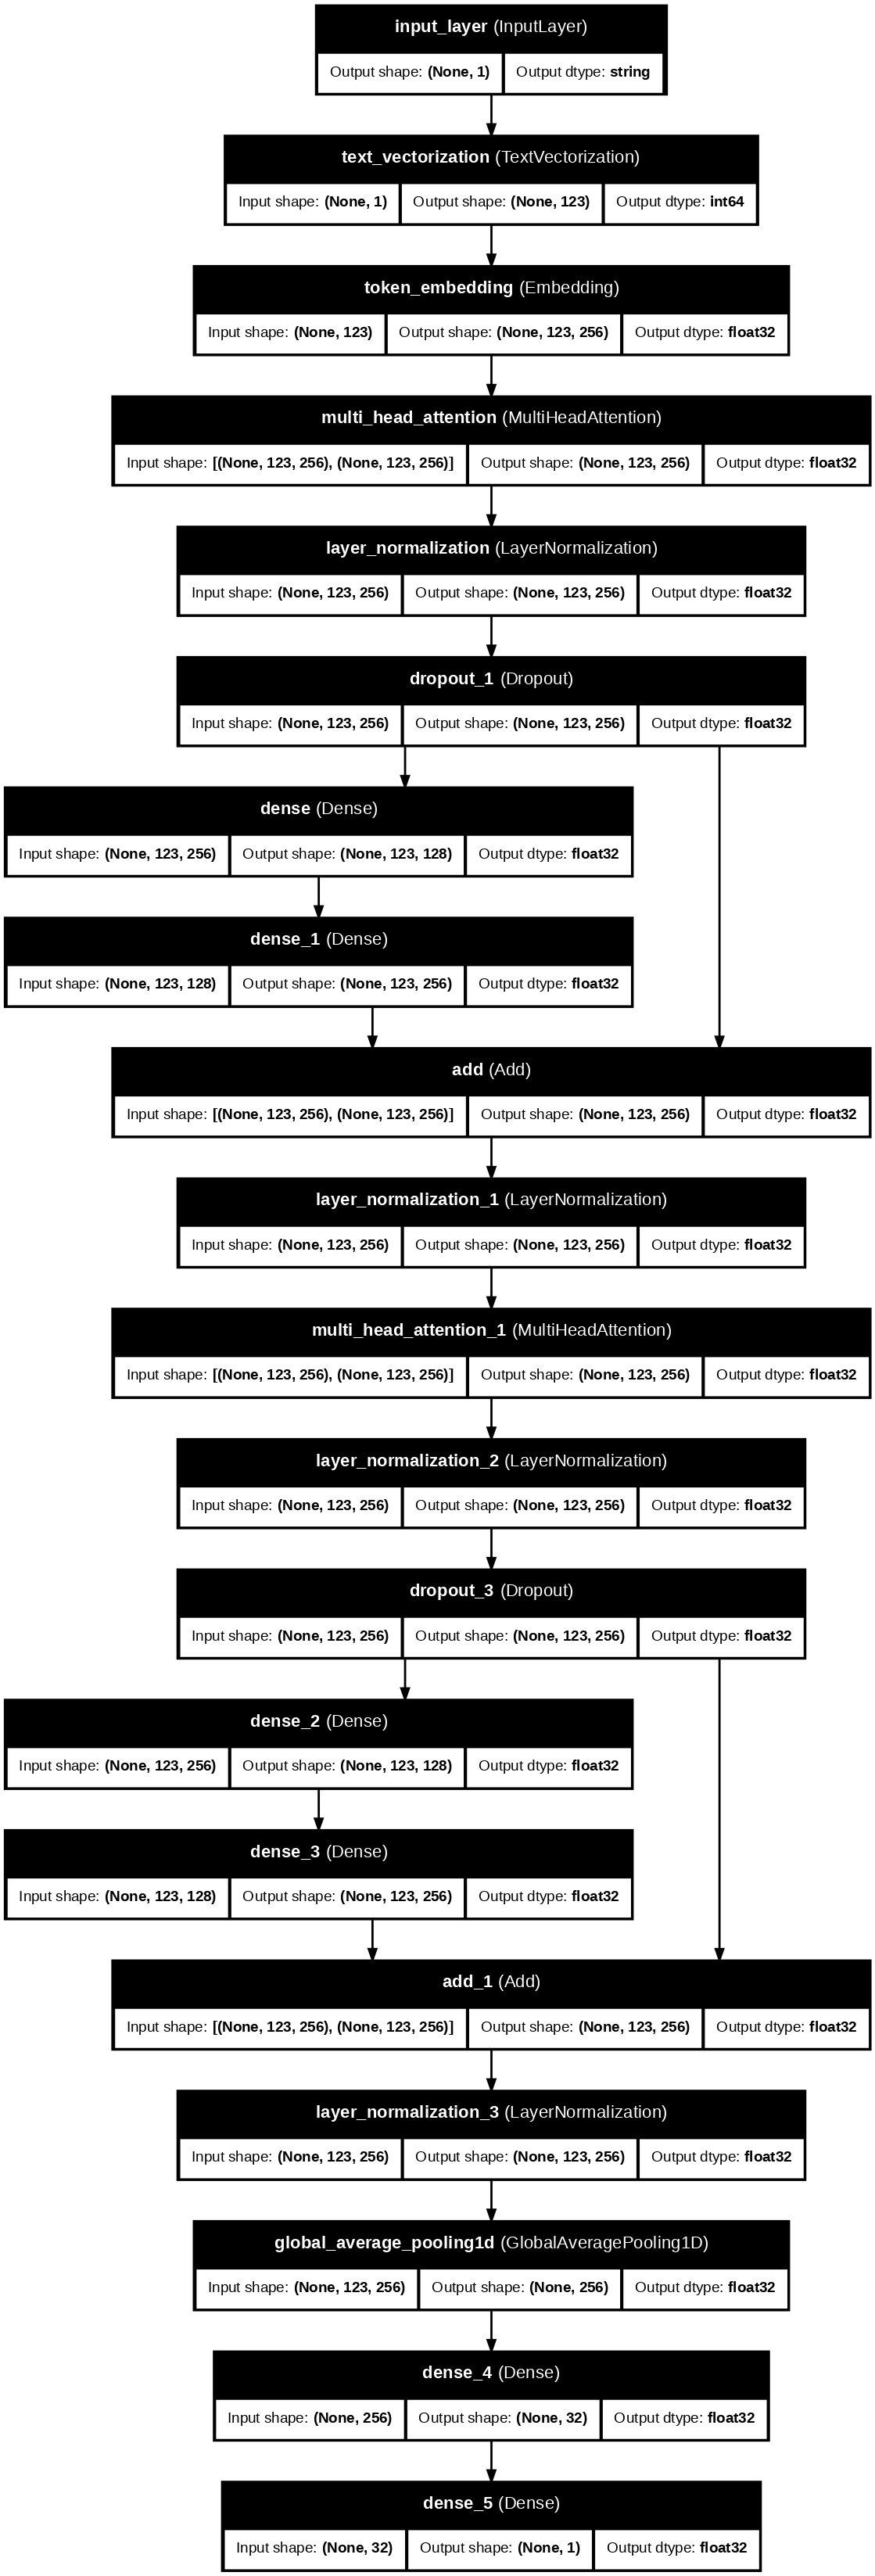

In [ ]:
keras.utils.plot_model(
    model_8,
    to_file="model_plot.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=100
)

# Model 9: BERT Embedding Regression

In [ ]:
BERT_MODEL_NAME = "bert-base-uncased"

In [ ]:
bert_tokenizer = tfs.BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
def bert_preprocess (texts, labels):
  encodings = bert_tokenizer(
      texts,
      padding = "max_length",
      truncation = True,
      max_length = 128,
      return_tensors = "tf"
  )

  return {
      "input_ids": encodings["input_ids"],
      "attention_mask": encodings["attention_mask"]
  }, labels

In [ ]:
bert_x_train, bert_y_train = bert_preprocess(X_train.tolist(), y_train)

In [ ]:
bert_x_train, bert_y_train

({'input_ids': <tf.Tensor: shape=(11424, 128), dtype=int32, numpy=
  array([[  101,  1197, 15290, ..., 29745, 18947,   102],
         [  101,  1194, 16856, ..., 22919,  1188,   102],
         [  101,  1191, 29748, ..., 22919, 15290,   102],
         ...,
         [  101,  1193, 29752, ..., 15290,  1189,   102],
         [  101,  1189, 29748, ..., 29745, 29749,   102],
         [  101,  1197, 10325, ...,     0,     0,     0]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(11424, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>},
 array([5., 5., 4., ..., 5., 5., 5.], dtype=float32))

In [ ]:
bert_x_test, bert_y_test = bert_preprocess(X_test.tolist(), y_test)

In [ ]:
bert_x_test, bert_y_test

({'input_ids': <tf.Tensor: shape=(2857, 128), dtype=int32, numpy=
  array([[  101,  1208, 22919, ...,     0,     0,     0],
         [  101,  1210,  1194, ..., 10325,  1195,   102],
         [  101,  1189, 29748, ...,     0,     0,     0],
         ...,
         [  101,  1197, 15290, ..., 28598, 18947,   102],
         [  101,  1185, 29742, ...,     0,     0,     0],
         [  101,  1182, 29745, ...,  1196, 14150,   102]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(2857, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>},
 array([1., 4., 5., ..., 5., 5., 1.], dtype=float32))

In [ ]:
bert = tfs.TFBertModel.from_pretrained("bert-base-uncased")

input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

bert_output = bert(input_ids, attention_mask=attention_mask)
pooled_output = bert_output.last_hidden_state[:, 0, :]
x = tf.keras.layers.Dense(128, activation="relu")(pooled_output)
x = tf.keras.layers.Dense(64, activation = "relu")(x)
output = tf.keras.layers.Dense(1, activation="linear")(x)

model_9 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model_9.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_12 (TFBertMo  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 del)                        ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                     

In [ ]:
model_9.compile(
  loss = "mse",
  optimizer = "Adam",
  metrics = ["mae"]
)

In [ ]:
model_9.fit(
    bert_x_train,
    bert_y_train,
    epochs = 1,
    batch_size = 32
)

357/357 [==============================] - 287s 804ms/step - loss: 1.8376 - mae: 1.0244


In [ ]:
model_9_preds = model_9.predict(bert_x_test)

90/90 [==============================] - 29s 269ms/step


In [97]:
model_9_preds

array([[4.2701464],
       [4.2701464],
       [4.2701464],
       ...,
       [4.270146 ],
       [4.2701464],
       [4.2701464]], dtype=float32)

In [98]:
y_test

array([1., 4., 5., ..., 5., 5., 1.], dtype=float32)

In [100]:
model_9_results = evaluate_model(y_test, model_9_preds)
model_9_results

{'MAE': 1.0115567445755005,
 'MSE': 1.8259382247924805,
 'RMSE': np.float64(1.35127281656684),
 'MSLE': 0.13233889639377594,
 'MAPE': 0.5297566652297974,
 'MedAE': np.float32(0.72985363),
 'R2': -0.0020194053649902344,
 'Explained Variance': -1.1920928955078125e-07}